## Teleport (Inline)

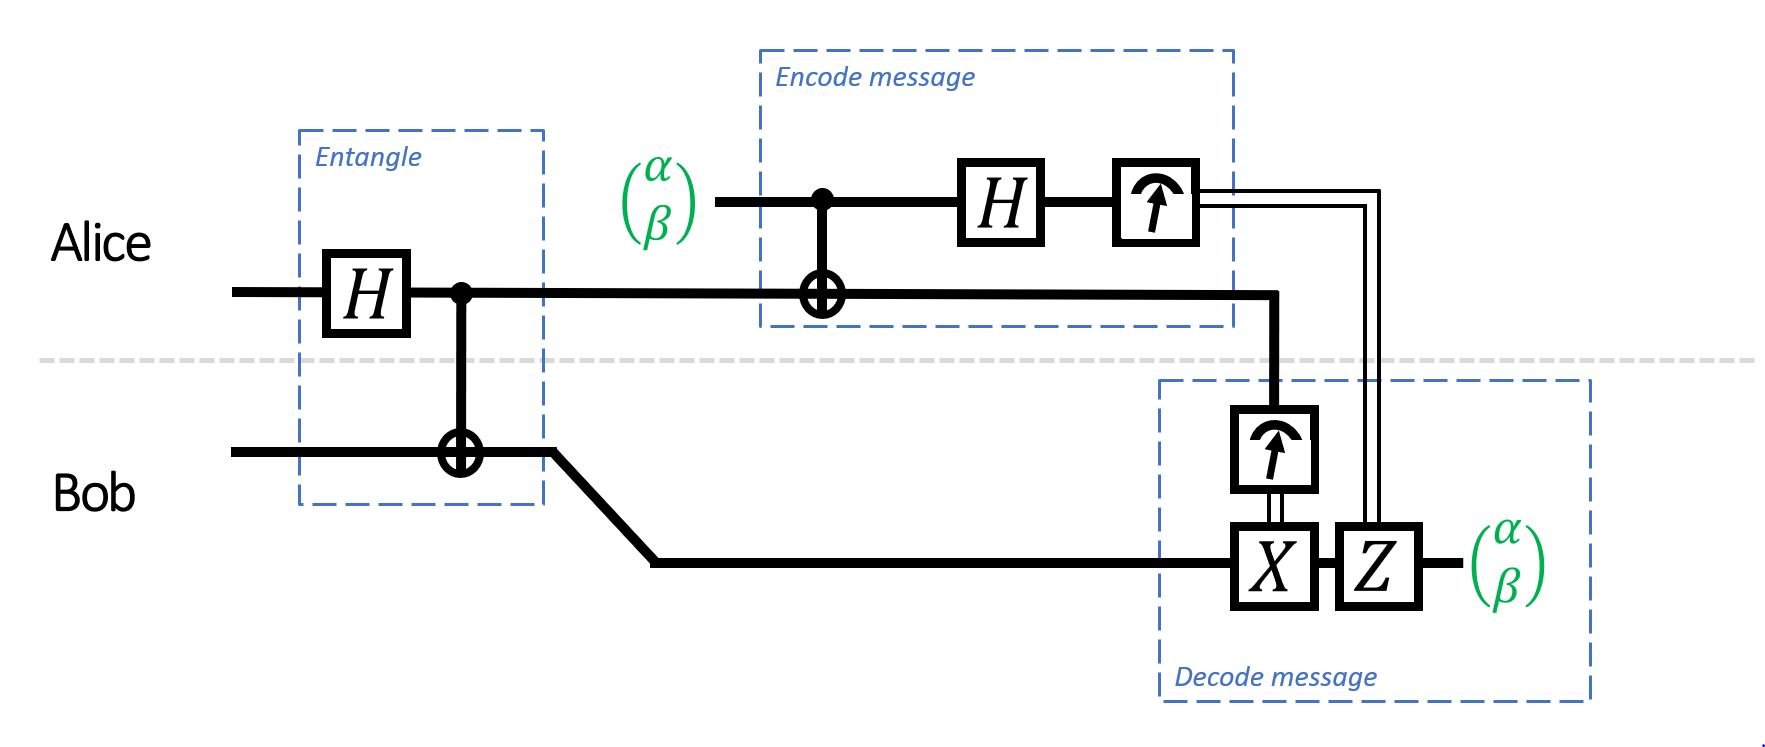

This is a version of Teleport that doesn't depend on the underlying workspace. 
It shows how to use IQ# to write a new Jupyter Notebook that uses Q# as the programming language.

To begin with, you can define Q# operations on a new cell. When the cell gets executed 
IQ# will compile the code. If the code is correct you will see the name of the operation 
as the output:


In [1]:
    /// # Summary
    /// Operation that takes |00> to (|00> + |11>)
    operation Entangle(q1: Qubit, q2: Qubit) : Unit {
        H(q1);
        CNOT(q1, q2);
    }

Entangle

If there are any syntax errors, you will instead see the errors listed. For example:

In [2]:
    operation InvalidOperation(Qubit q1, q2: Qubit) : Unit {
        FooBar(q1);
    }

C:/snippet:(1,116): error QS3225: Invalid argument declaration. Expecting a symbol declaration followed by a type  ("symbolName : SymbolType").
C:/snippet:(2,9): error QS5022: No variable with that name exists.
C:/snippet:(2,16): error QS5022: No variable with that name exists.


You can create multiple operations in one single cell. The name of all the operations will be in the output:

In [3]:
    /// -------------------------------
    /// Helper operations
    /// -------------------------------
    

    /// # Summary
    /// Sets the qubit's state to |+>
    operation SetPlus(q: Qubit) : Unit {
        Reset(q);
        H(q);
    }
    
    /// # Summary
    /// Sets the qubit's state to |->
    operation SetMinus(q: Qubit) : Unit {
        Reset(q);
        X(q);
        H(q);
    }

    /// # Summary
    /// Returns true if qubit is |+> (assumes qubit is either |+> or |->)
    operation IsPlus(q: Qubit) : Bool {
        return (Measure([PauliX], [q]) == Zero);
    }

    /// # Summary
    /// Returns true if qubit is |-> (assumes qubit is either |+> or |->)
    operation IsMinus(q: Qubit) : Bool {
        return (Measure([PauliX], [q]) == One);
    }
    
    /// # Summary
    /// Randomly prepares the qubit into |+> or |->
    operation PrepareRandomMessage(q: Qubit) : Unit {
        
        let choice = RandomInt(2);

        if (choice == 0) {
            Message("Sending |->");
            SetMinus(q);
        } else {
            Message("Sending |+>");
            SetPlus(q);
        }
    }

IsMinus, IsPlus, PrepareRandomMessage, SetMinus, SetPlus

Once defined, these operations can be used in other code snippets.

So, with all these helper operations in place, let's show how to write Teleport.

To begin with, define an `Encode` operation.
This is what Alice does: encodes a random message
using an entangled qubit (channel) that she shares with Bob.
This method returns the classical piece of data that Bob needs to 
decode the message.


In [4]:
    operation Encode(channel: Qubit) : Result {
        mutable r = Zero;

        using (msg = Qubit()) {
            PrepareRandomMessage(msg);
            CNOT(msg, channel);
            H(msg);
            set r = M(msg);

            Reset(msg);
        }

        return r;
    }


Encode

Now define `Decode` which is what Bob's does: 
decodes the message sent by Alice from the entangled qubit (channel)
with the piece of classical info sent by her.

After decoding, `msg` contains the original state sent by Alice.


In [5]:
    operation Decode(channel : Qubit, classicalInfo : Result, msg : Qubit) : Unit {
        if (M(channel) == One) { X(msg); }
        if (classicalInfo == One) { Z(msg); }
    }


Decode

With these two operations in place, it's now easy to write a Teleport version that works end to end:

In [6]:
    operation Teleport() : Unit {
        using (qubits = Qubit[2]) {
            let msg = qubits[0];
            let channel = qubits[1];

            // Entangle
            Entangle(channel, msg);

            // Ask Alice to encode message on entangled qubit
            let classicInfo = Encode(channel);

            // Decode Alice's message into the msg qubit:
            Decode(channel, classicInfo, msg);
            
            // Report message received:
            if (IsPlus(msg))  { Message("Received |+>"); }
            if (IsMinus(msg)) { Message("Received |->"); }

            ResetAll(qubits);
        }
    }

Teleport

To simulate this operation, use the `%simulate` magic.

In [7]:
%simulate Teleport

Sending |+>
Received |+>


()

You can also wrap this into another Q# operation to iterate 10 times on it:

In [8]:
operation IterateTeleport() : Unit {
    for(i in 1..10) {
        Teleport();
        Message("---------------");
    }
}

IterateTeleport

In [9]:
%simulate IterateTeleport

Sending |->
Received |->
---------------
Sending |+>
Received |+>
---------------
Sending |->
Received |->
---------------
Sending |->
Received |->
---------------
Sending |->
Received |->
---------------
Sending |->
Received |->
---------------
Sending |->
Received |->
---------------
Sending |+>
Received |+>
---------------
Sending |->
Received |->
---------------
Sending |->
Received |->
---------------


()

or use `%estimate` to get an estimation of resources:

In [10]:
%estimate IterateTeleport

Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------
Sending |->
Received |+>
---------------


[CNOT, 20], [QubitClifford, 40], [R, 0], [Measure, 80], [T, 0], [Depth, 0], [Width, 3], [BorrowedWidth, 0]

In [11]:
%version

Component,Version
iqsharp,0.5.1902.2802
Jupyter Core,1.0.0.0
